In [1]:
from multiprocess import Pool

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit, minimize


from neurodsp.sim.cycles import sim_normalized_cycle
from bycycle.recon.recon_obj import BycycleRecon, DEFAULT_OPT

### Simulate

Simulate each cycle type provided by neurodsp.

In [2]:
# Drop affine bounds and guess
BOUNDS = {}
P0 = {}
KEYS = {}

for k in DEFAULT_OPT:
    _bounds = []
    _p0 = []
    for p in DEFAULT_OPT[k]:
        
        if not p.startswith('affine'):
            _bounds.append(DEFAULT_OPT[k][p]['bounds'])
            _p0.append(DEFAULT_OPT[k][p]['p0'])
        
    BOUNDS[k] = _bounds
    P0[k] = _p0
    KEYS[k] = [i for i in list(DEFAULT_OPT[k].keys()) if not i.startswith('affine')]

In [3]:
# Simulation loop
n_sims = 10
n_samples = 100

cycle_targets = {}
sim_kwargs = {}
target_values = []

for cyc_type in DEFAULT_OPT.keys():

    
    sim_kwargs[cyc_type] = {}
    dtypes = [type(i) for i in P0[cyc_type]]
    # Sample random uniforms from lower to upper bounds on each parameter
    for ikwarg, (k, b) in enumerate(zip(KEYS[cyc_type], BOUNDS[cyc_type])):
        sim_kwargs[cyc_type][k] = np.random.uniform(b[0], b[1], n_sims).astype(dtypes[ikwarg])
        
    # Recon class had to rename 2exp to double_exp
    #   e.g. can't have class attribute start with a number
    if cyc_type == 'double_exp':
        sim_cyc_type = '2exp'
    else:
        sim_cyc_type = cyc_type

    # Simulate
    cycle_targets[cyc_type] = np.zeros((n_sims, n_samples))
    for isim in range(n_sims):

        kwargs = {k: v[isim] for k, v in sim_kwargs[cyc_type].items() if k != 'phase'}
        
        # Seed and simulate
        cycle_targets[cyc_type][isim] = sim_normalized_cycle(
            1, 100, sim_cyc_type, phase='min', **kwargs
        )[:100] + np.random.rand(100) / 5

/Users/ryanhammonds/projects/bycycle/.env/lib/python3.11/site-packages/neurodsp/sim/transients.py:67: UserWarning: Rise time constant should be shorter than decay time constant.
  warn('Rise time constant should be shorter than decay time constant.')


### Fit

Each `.fit` call optimizes each cycle type's parameters (simulation and affine parameters) against the provided input cycle(s). A priori hypothesis of the expected cycles types can be defined to decrease runtime. Here, each set of simulated cycles are compared against the same simulator model to show that ground truth parameters can be recovered. In a few cases multiple simulators can fit data produced from another.

In [4]:
# Each .fit call optimizes each cycle type's parmeters
#   against the provided input cycle(s)
models = list(DEFAULT_OPT.keys())
models

['sine',
 'asine',
 'asym_harmonic',
 'double_exp',
 'exp_cos',
 'gaussian',
 'skewed_gaussian',
 'sawtooth']

### Sine

All models can fit sine waves resonably well.

0.9966381882693126

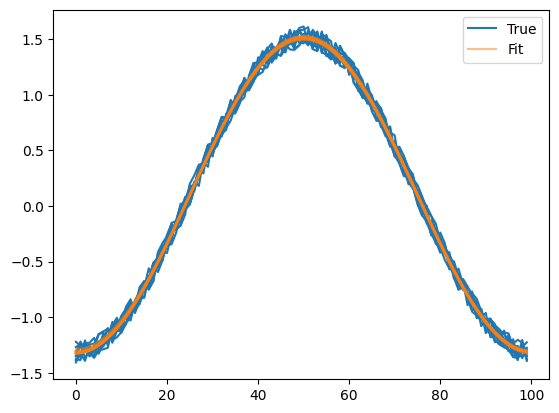

In [5]:
# Use all available models and fit sine simulations
br = BycycleRecon(cycles=models)
br.fit(cycle_targets['sine'])

# Check the sine model
br.models.sine.plot() 
br.models.sine.rsq.mean()

In [6]:
# All models can produce resonable fits for sine
for m in models:
    print(m, 'rsq = ', getattr(br.models, m).rsq.mean())

sine rsq =  0.9966381882693126
asine rsq =  0.9933308387582507
asym_harmonic rsq =  0.9484584463149321
double_exp rsq =  0.8929174236868699
exp_cos rsq =  0.9966649223561383
gaussian rsq =  0.9955552460227872
skewed_gaussian rsq =  0.9959576037696787
sawtooth rsq =  0.982311746453877


### Asine

0.9909167902039506

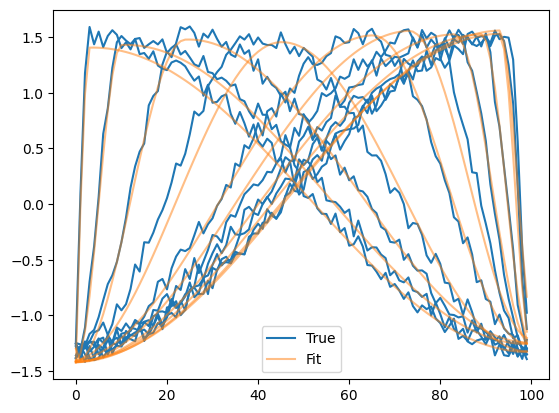

In [7]:
br = BycycleRecon()
br.fit(cycle_targets['asine'])
br.models.asine.plot() 
br.models.asine.rsq.mean()

In [8]:
# R-squared of each model
for m in models:
    print(m, 'rsq = ', getattr(br.models, m).rsq.mean())

sine rsq =  0.7781969719777339
asine rsq =  0.9909167902039506
asym_harmonic rsq =  0.8153745812343491
double_exp rsq =  0.8073940327005513
exp_cos rsq =  0.8233689658167661
gaussian rsq =  0.8085788936395908
skewed_gaussian rsq =  0.9371007299746944
sawtooth rsq =  0.9504128244468106


### Asymmetrical Harmonic

0.9615194265277486

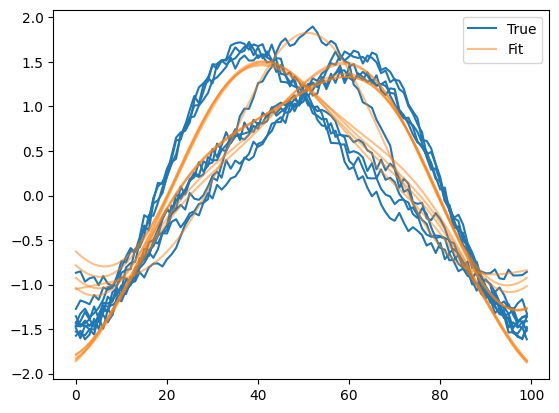

In [9]:
# needs a better p0
br.fit(cycle_targets['asym_harmonic'])
br.models.asym_harmonic.plot() 
br.models.asym_harmonic.rsq.mean()

In [10]:
# R-squared of each model
for m in models:
    print(m, 'rsq = ', getattr(br.models, m).rsq.mean())

sine rsq =  0.8785919809256832
asine rsq =  0.9712522738504594
asym_harmonic rsq =  0.9615194265277486
double_exp rsq =  0.8626801658539245
exp_cos rsq =  0.9095906020718832
gaussian rsq =  0.9084391756871147
skewed_gaussian rsq =  0.9714575282133964
sawtooth rsq =  0.9724862619928798


### Double Exponential

0.9966798645409813

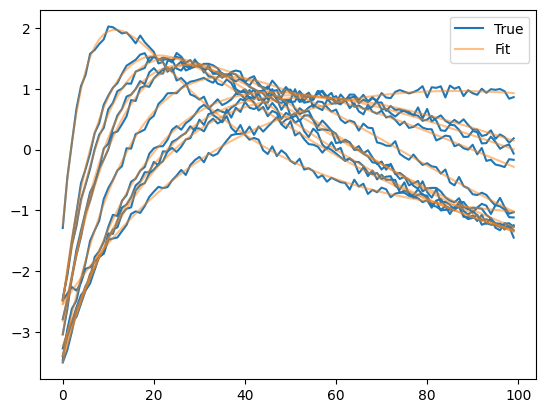

In [11]:
br.fit(cycle_targets['double_exp'])
br.models.double_exp.plot() 
br.models.double_exp.rsq.mean()

In [12]:
# R-squared of each model
for m in models:
    print(m, 'rsq = ', getattr(br.models, m).rsq.mean())

sine rsq =  0.7178801053507985
asine rsq =  0.8819579114561691
asym_harmonic rsq =  0.7790836906671863
double_exp rsq =  0.9966798645409813
exp_cos rsq =  0.8446156426077283
gaussian rsq =  0.7992628787202343
skewed_gaussian rsq =  0.9210160388969998
sawtooth rsq =  0.9623971485782639


### Exponential Cosine

0.9966082856863275

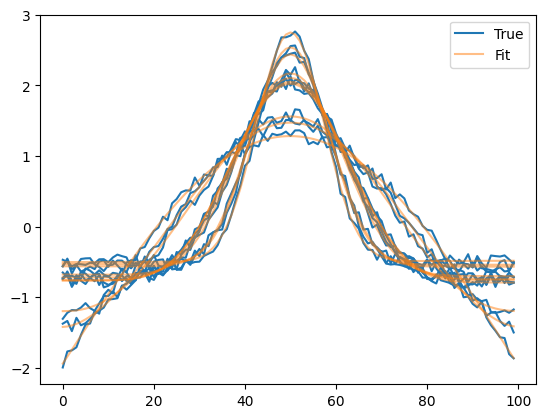

In [13]:
br.fit(cycle_targets['exp_cos'])
br.models.exp_cos.plot() 
br.models.exp_cos.rsq.mean()

In [14]:
# R-squared of each model
for m in models:
    print(m, 'rsq = ', getattr(br.models, m).rsq.mean())

sine rsq =  0.8094775732188977
asine rsq =  0.8070717071743821
asym_harmonic rsq =  0.9121876256428475
double_exp rsq =  0.6321150594506251
exp_cos rsq =  0.9966082856863275
gaussian rsq =  0.9946615528295334
skewed_gaussian rsq =  0.9928150079759771
sawtooth rsq =  0.8221079468194981


### Gaussian

0.996764133354508

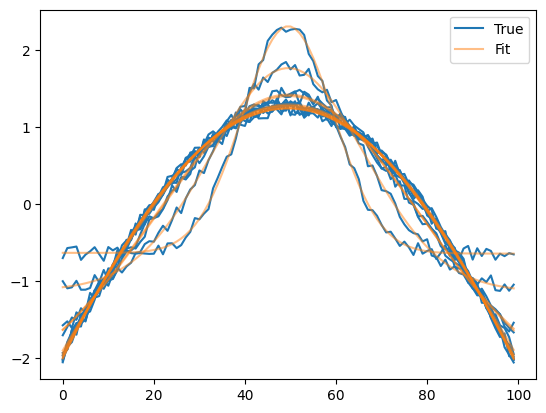

In [15]:
br.fit(cycle_targets['gaussian'])
br.models.gaussian.plot() 
br.models.gaussian.rsq.mean()

In [16]:
# R-squared of each model
for m in models:
    print(m, 'rsq = ', getattr(br.models, m).rsq.mean())

sine rsq =  0.9309862099008788
asine rsq =  0.9306078470525273
asym_harmonic rsq =  0.9722716717166735
double_exp rsq =  0.9040207067051502
exp_cos rsq =  0.996237173732102
gaussian rsq =  0.996764133354508
skewed_gaussian rsq =  0.9720649602554772
sawtooth rsq =  0.9377653966816448


### Skewed Gaussian

0.9968734719501399

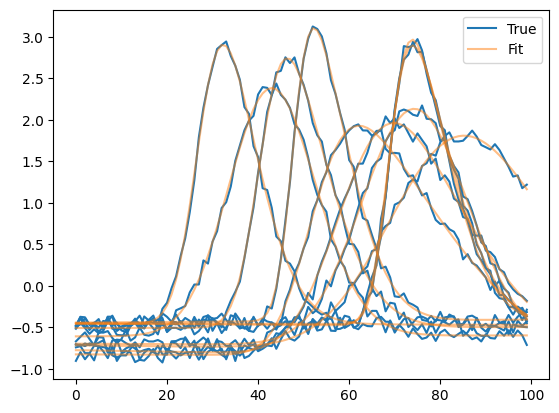

In [17]:
br.fit(cycle_targets['skewed_gaussian'][:10])
br.models.skewed_gaussian.plot() 
br.models.skewed_gaussian.rsq.mean()

In [18]:
# R-squared of each model
for m in models:
    print(m, 'rsq = ', getattr(br.models, m).rsq.mean())

sine rsq =  0.49575056519163907
asine rsq =  0.6601710158028807
asym_harmonic rsq =  0.588338710127887
double_exp rsq =  0.462479171480186
exp_cos rsq =  0.5964119488728499
gaussian rsq =  0.584493016414822
skewed_gaussian rsq =  0.9968734719501399
sawtooth rsq =  0.613536314806677


### Sawtooth

0.981731630056865

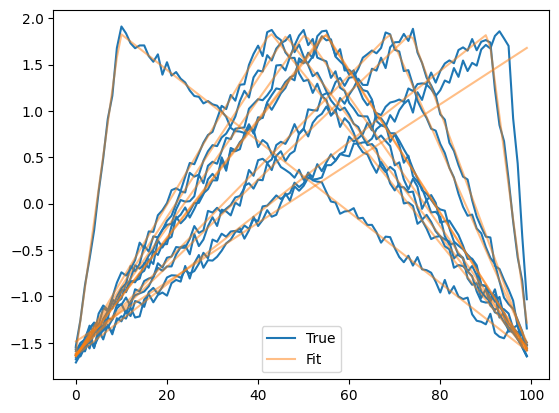

In [19]:
br.fit(cycle_targets['sawtooth'])
br.models.sawtooth.plot() 
br.models.sawtooth.rsq.mean()

In [20]:
# R-squared of each model
for m in models:
    print(m, 'rsq = ', getattr(br.models, m).rsq.mean())

sine rsq =  0.8597390130679962
asine rsq =  0.9804815641931295
asym_harmonic rsq =  0.8853309557043703
double_exp rsq =  0.8502798152294103
exp_cos rsq =  0.8948676069117057
gaussian rsq =  0.8845620084933306
skewed_gaussian rsq =  0.9417843430723176
sawtooth rsq =  0.981731630056865
